# Analysis of the Global Covid-19 Vaccination Progress

This Notebook analyzes the progress of covid vaccination in different countries by investigation the [COVID-19 World Vaccination Progress Dataset](https://www.kaggle.com/gpreda/covid-world-vaccination-progress) from [Our World Data](https://ourworldindata.org/). The data is enriched with [GDP per Capita Information](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD) provided by the world bank and [country population information](https://population.un.org/wpp/Download/Standard/CSV/) provided by the United Nations. The enriched data allows insights into the demographic and economic situations of the analysed countries and their progress on vaccinating their citizens. The data is being transformed to optimize the analytical insights.

The notebook is structured as followed:

* **Data Cleaning and Merging**: Reading and merging the collected datasets
    * Drop unused columns
    * Drop columns with missing values
    * Transform categorical values (vaccines column)
    
    
* **Exploratory Data Analysis**: Deliver insights into the data by analysing the following questions:
    * Recent Daily Vaccinations per million citizens per country
    * US Daily Vaccination Rate
    * Association between GDP per Capita and percent of vaccinated citizens
    * Association between population size and percent of vaccinated citizens
    * Regression Coefficients for population size, GDP per Capita and population density
    * Vaccines Analysis: Are there vaccines mainly accessible for countries with a high GDP per Capita?

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__)

1.0.5
1.18.5
3.2.2
0.11.1
0.23.1


In [2]:
#Read in the Dataset and investigate the dimensions

df=pd.read_csv('.\data\country_vaccinations.csv')
df_gdp=pd.read_csv('.\data\country_gdp.csv',delimiter=';')
df_pop=pd.read_csv('.\data\country_population.csv')
print('Shape of dataset:',df.shape,df_gdp.shape,df_pop.shape)
print('Columns in dataset:',df.columns)
available_countries=list(df.country.unique())
df.head()

Shape of dataset: (1427, 15) (264, 3) (280932, 10)
Columns in dataset: Index(['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website'],
      dtype='object')


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Argentina,ARG,2020-12-29,700.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
1,Argentina,ARG,2020-12-30,NaN,NaN,NaN,NaN,15656.0,NaN,NaN,NaN,346.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
2,Argentina,ARG,2020-12-31,32013.0,NaN,NaN,NaN,15656.0,0.07,NaN,NaN,346.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
3,Argentina,ARG,2021-01-01,NaN,NaN,NaN,NaN,11070.0,NaN,NaN,NaN,245.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...
4,Argentina,ARG,2021-01-02,NaN,NaN,NaN,NaN,8776.0,NaN,NaN,NaN,194.0,Sputnik V,Ministry of Health,http://datos.salud.gob.ar/dataset/vacunas-cont...


### Data Cleaning and Merging

In [3]:
#Merge datasets for analysis (gdp)
df_gdp=df_gdp.rename(columns={'Country Name':'country'})
df_merged=pd.merge(df,df_gdp,on=['country'],how='inner')
df_merged['date']=pd.to_datetime(df_merged['date'])

#check missing countries
merged_countries=list(df_merged.country.unique())
print('Failed to merge Countries:',set(available_countries)-set(merged_countries))
df_merged.shape

Failed to merge Countries: {'Wales', 'England', 'Scotland', 'Northern Ireland'}


(1266, 17)

In [4]:
#Clean missing data and drop columns
df_merged=df_merged.drop(columns=['daily_vaccinations_raw','source_name','source_website','Indicator Name','people_vaccinated','people_fully_vaccinated','people_fully_vaccinated_per_hundred','people_vaccinated_per_hundred'])

#Remove rows with "total/daily vaccinations" and GDP missing
df_cleaned=df_merged.dropna(axis=0,subset=['total_vaccinations','daily_vaccinations','2019'])
df_cleaned=df_cleaned.rename(columns={'2019':'GDP_per_Capita'})
df_cleaned.isnull().sum()

country                           0
iso_code                          0
date                              0
total_vaccinations                0
daily_vaccinations                0
total_vaccinations_per_hundred    0
daily_vaccinations_per_million    0
vaccines                          0
GDP_per_Capita                    0
dtype: int64

In [5]:
#filter and join population size data (only most recent number relevant)
sorted = df_pop.sort_values(by='Time')
df_pop_filtered = sorted.drop_duplicates('Location', keep='last')
df_pop_filtered=df_pop_filtered.rename(columns={'Location':'country'})

In [6]:
df_tot=pd.merge(df_cleaned,df_pop_filtered,on=['country'],how='inner')
df_tot=df_tot.drop(columns=['LocID','VarID','Variant','Time','MidPeriod','PopMale','PopFemale'])

df_tot.head()

,country,iso_code,date,total_vaccinations,daily_vaccinations,total_vaccinations_per_hundred,daily_vaccinations_per_million,vaccines,GDP_per_Capita,PopTotal,PopDensity
0,Argentina,ARG,2020-12-31,32013.0,15656.0,0.07,346.0,Sputnik V,9912.281809,56802.493,20.756
1,Argentina,ARG,2021-01-04,39599.0,6483.0,0.09,143.0,Sputnik V,9912.281809,56802.493,20.756
2,Argentina,ARG,2021-01-08,107542.0,10519.0,0.24,233.0,Sputnik V,9912.281809,56802.493,20.756
3,Argentina,ARG,2021-01-13,166833.0,13323.0,0.37,295.0,Sputnik V,9912.281809,56802.493,20.756
4,Argentina,ARG,2021-01-15,200759.0,13317.0,0.44,295.0,Sputnik V,9912.281809,56802.493,20.756


In [7]:
# 0/1 encode categorical values of the vaccines column

df_tot['Pfizer']=df_tot['vaccines'].apply(lambda x: 1 if 'Pfizer/BioNTech' in x else 0)
df_tot['Sinopharm']=df_tot['vaccines'].apply(lambda x: 1 if 'Sinopharm' in x else 0)
df_tot['Moderna']=df_tot['vaccines'].apply(lambda x: 1 if 'Moderna' in x else 0)
df_tot['Sinovac']=df_tot['vaccines'].apply(lambda x: 1 if 'Sinovac' in x else 0)
df_tot['Astra']=df_tot['vaccines'].apply(lambda x: 1 if 'Oxford/AstraZeneca' in x else 0)

## Exploratory Data Analysis

In [8]:
#List of analyzed countrys
print('List of Countries being analyzed: \n',df_tot['country'].unique())
print('\n Number of countries being analyzed:', len(df_tot['country'].unique()))

List of Countries being analyzed: 
 ['Argentina' 'Austria' 'Bahrain' 'Belgium' 'Brazil' 'Bulgaria' 'Canada'
 'Chile' 'China' 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Denmark'
 'Ecuador' 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Ireland' 'Israel' 'Italy' 'Latvia'
 'Lithuania' 'Luxembourg' 'Malta' 'Mexico' 'Netherlands' 'Norway' 'Oman'
 'Panama' 'Poland' 'Portugal' 'Romania' 'Saudi Arabia' 'Serbia'
 'Seychelles' 'Singapore' 'Slovakia' 'Slovenia' 'Spain' 'Sweden'
 'Switzerland' 'Turkey' 'United Arab Emirates' 'United Kingdom']

 Number of countries being analyzed: 51


In [9]:
#Investigate the data
df_tot.describe()

,total_vaccinations,daily_vaccinations,total_vaccinations_per_hundred,daily_vaccinations_per_million,GDP_per_Capita,PopTotal,PopDensity,Pfizer,Sinopharm,Moderna,Sinovac,Astra
count,8.030000e+02,803.000000,803.000000,803.000000,803.000000,8.030000e+02,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000
mean,3.951962e+05,27677.678705,2.279776,1481.927771,31323.564272,5.004936e+04,226.336613,0.937733,0.073474,0.281445,0.031133,0.019925
std,1.046660e+06,58432.513782,5.286618,2875.584648,19769.916645,2.283429e+05,511.712956,0.241790,0.261076,0.449984,0.173786,0.139831
min,6.000000e+00,1.000000,0.000000,0.000000,2099.599048,7.561500e+01,4.551000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.828100e+04,1848.000000,0.255000,272.000000,15731.016030,3.829211e+03,24.169000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,6.328000e+04,5857.000000,0.730000,659.000000,23503.977130,1.038790e+04,75.213000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2.489120e+05,27754.500000,1.640000,1087.000000,46194.725230,2.871089e+04,184.329000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.500000e+07,714286.000000,41.770000,19604.000000,114704.594200,2.181574e+06,6484.990000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Recent Daily Vaccinations per million citizens per country

Which countries are vaccinating the highest percentage of their citizens every day?

In [10]:
#Current Vaccination Status per country
sorted = df_tot.sort_values(by='date')
df_recent = sorted.drop_duplicates('country', keep='last')
df_recent = df_recent.sort_values(by='daily_vaccinations_per_million')

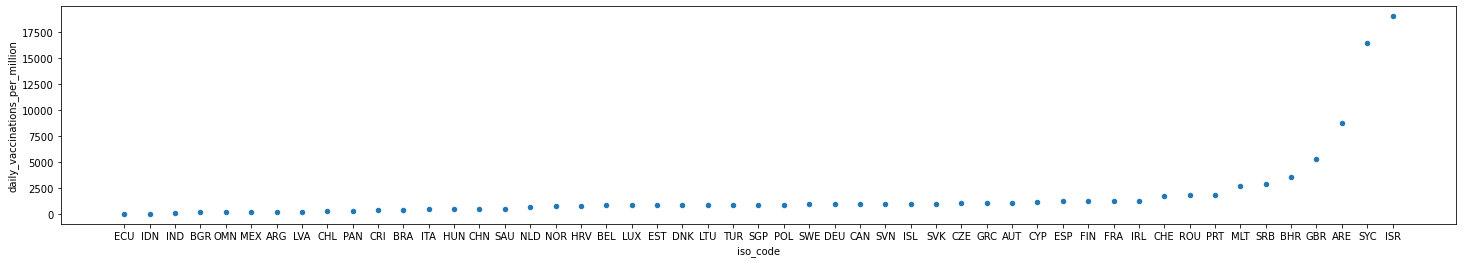

In [11]:
curr=df_recent[['daily_vaccinations_per_million','iso_code']]
curr.plot.scatter(x='iso_code',y='daily_vaccinations_per_million',figsize=(25,4))

#### US Daily Vaccination Rate
How fast is the US improving their daily vaccination numbers?

In [12]:
df_US=df_cleaned[df_cleaned['country']=='United States'][['date','daily_vaccinations']]

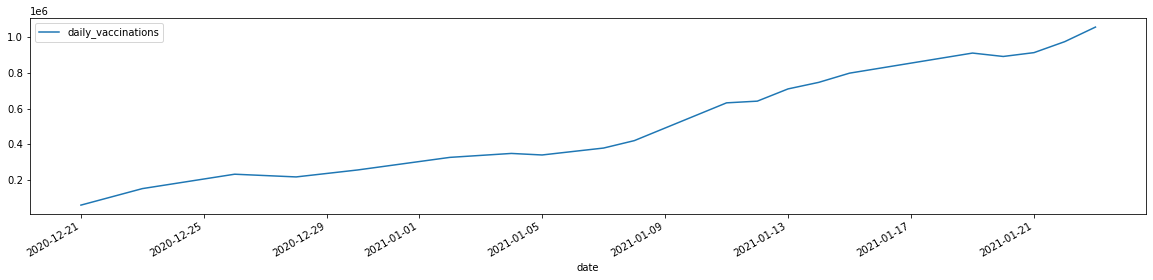

In [13]:
df_US.plot(x='date',y='daily_vaccinations',figsize=(20,4))

### Association between GDP per Capita and percent of vaccinated citizens
Are wealthy nations able to vaccine more citizens than countries?

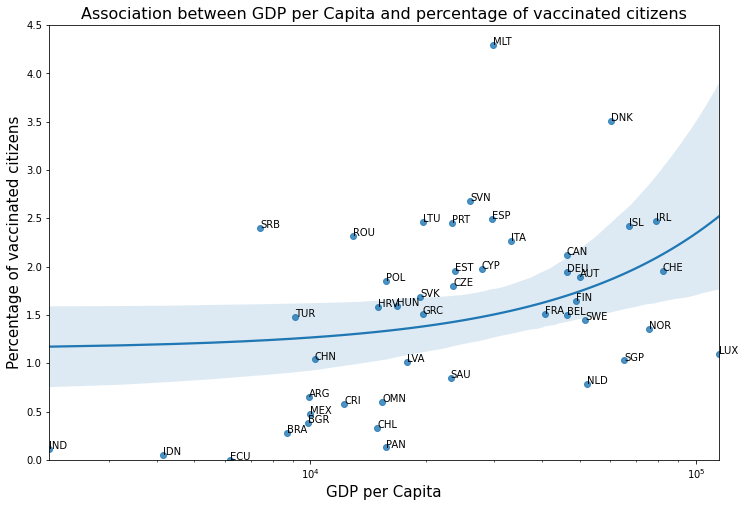

In [14]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
df_recent = df_recent.sort_values(by='GDP_per_Capita')
curr=df_recent[['GDP_per_Capita','iso_code','total_vaccinations_per_hundred']]

#remove outliers
curr=curr[~curr['iso_code'].isin(['ISR','ARE','SYC','GBR','BHR'])]

plt.figure(figsize=(12,8))

splot=sns.regplot(data=curr,x='GDP_per_Capita',y='total_vaccinations_per_hundred')
splot.set(xscale='log',ylim=[0,4.5])
label_point(curr.GDP_per_Capita, curr.total_vaccinations_per_hundred, curr.iso_code, plt.gca())
splot.axes.set_title("Association between GDP per Capita and percentage of vaccinated citizens",fontsize=16)
splot.set_xlabel('GDP per Capita',fontsize=15)
splot.set_ylabel('Percentage of vaccinated citizens',fontsize=15)

fig=splot.get_figure()
fig.savefig("GDP_vs_PercVacc.png")

### Association between population size and percent of vaccinated citizens

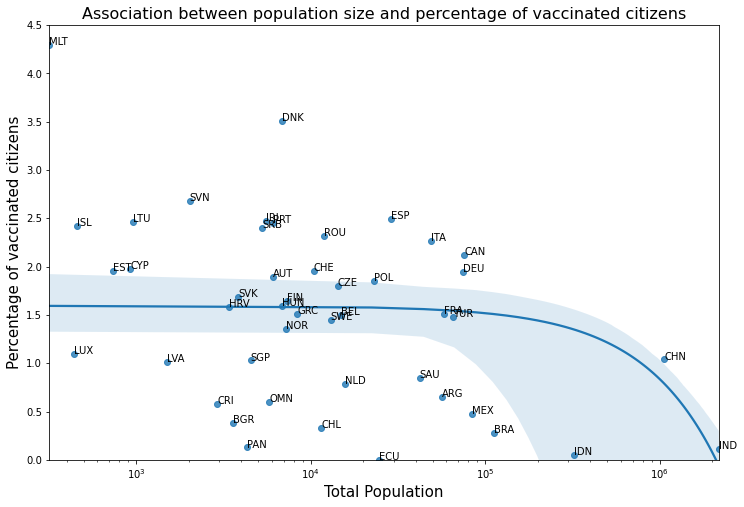

In [15]:
df_recent = df_recent.sort_values(by='PopTotal')
curr=df_recent[['PopTotal','iso_code','total_vaccinations_per_hundred']]

#remove outliers
curr=curr[~curr['iso_code'].isin(['ISR','ARE','SYC','GBR','BHR'])]

plt.figure(figsize=(12,8))

splot=sns.regplot(data=curr,x='PopTotal',y='total_vaccinations_per_hundred')
splot.set(xscale='log',ylim=[0,4.5])
label_point(curr.PopTotal, curr.total_vaccinations_per_hundred, curr.iso_code, plt.gca()) 
splot.axes.set_title("Association between population size and percentage of vaccinated citizens",fontsize=16)
splot.set_xlabel('Total Population',fontsize=15)
splot.set_ylabel('Percentage of vaccinated citizens',fontsize=15)

fig=splot.get_figure()
fig.savefig("PopSize_vs_PercVacc.png")

### Regression Coefficients for population size, GDP per Capita and population density

In [16]:
y=np.array(df_recent[['total_vaccinations_per_hundred']])
X=np.array(df_recent[['GDP_per_Capita','PopTotal','PopDensity']])

In [17]:
reg = LinearRegression().fit(X, y)

In [18]:
reg.coef_

array([[ 2.32138617e-05, -1.63475623e-06,  2.81426369e-04]])

### Vaccines Analysis

Are there vaccines that are mostly available to countries with high GDP per Capita?

In [19]:
df_recent['vaccines'].value_counts()

Pfizer/BioNTech                          30
Moderna, Pfizer/BioNTech                 10
Sinovac                                   3
Pfizer/BioNTech, Sinopharm                2
Oxford/AstraZeneca, Pfizer/BioNTech       1
Sinopharm                                 1
Sputnik V                                 1
Covaxin, Covishield                       1
CNBG, Sinovac                             1
Pfizer/BioNTech, Sinopharm, Sputnik V     1
Name: vaccines, dtype: int64

In [20]:
vaccines=['Pfizer','Sinopharm','Moderna','Sinovac','Astra']
avg_gdp=[]
nr_countries=[]
for i in vaccines:
    tot=0
    n=0
    for k,j in enumerate(df_recent['GDP_per_Capita']):
        if df_recent[i].iloc[k]==1:
            n+=1
            tot+=j
    avg=tot/n
    avg_gdp.append(avg)
    nr_countries.append(n)
    print('{} is used by {} countries and avg gdp is {}'.format(i,n,avg))

Pfizer is used by 44 countries and avg gdp is 35142.85226397728
Sinopharm is used by 4 countries and avg gdp is 22866.851649
Moderna is used by 10 countries and avg gdp is 39820.356415500006
Sinovac is used by 4 countries and avg gdp is 8060.249034249999
Astra is used by 1 countries and avg gdp is 42330.11754


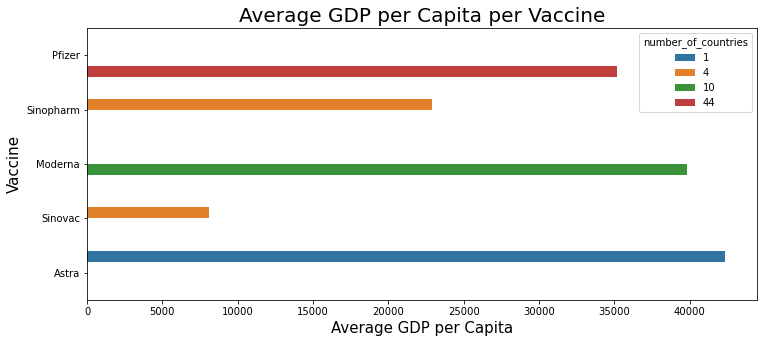

In [21]:
d={'Vaccine':vaccines,'avg_gdp':avg_gdp,'number_of_countries':nr_countries}
df=pd.DataFrame(d)
plt.figure(figsize=(12,5))
splot=sns.barplot(data=df,x='avg_gdp',y='Vaccine',hue='number_of_countries')
splot.axes.set_title("Average GDP per Capita per Vaccine",fontsize=20)
splot.set_xlabel('Average GDP per Capita',fontsize=15)
splot.set_ylabel('Vaccine',fontsize=15)
fig=splot.get_figure()
fig.savefig("Vacc_plot.png")